The companies are interested in answering two questions:

- Would the campaign be successful?
- If the campaign was successful, how much of that success could be attributed to the ads?
With the second question in mind, we normally do an A/B test. The majority of the people will be exposed to ads (the experimental group). And a small portion of people (the control group) would instead see a Public Service Announcement (PSA) (or nothing) in the exact size and place the ad would normally be.

The idea of the dataset is to analyze the groups, find if the ads were successful, how much the company can make from the ads, and if the difference between the groups is statistically significant.

Data dictionary:

- Index: Row index
- user id: User ID (unique)
- test group: If "ad" the person saw the advertisement, if "psa" they only saw the public service announcement
- converted: If a person bought the product then True, else is False
- total ads: Amount of ads seen by person
- most ads day: Day that the person saw the biggest amount of ads
- most ads hour: Hour of day that the person saw the biggest amount of ads

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import norm
import math

import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('/content/marketing_AB.csv')

In [6]:
df.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


# EDA and Data Preprocessing

In [7]:
df.describe()

,Unnamed: 0,user id,total ads,most ads hour
count,588101.000000,5.881010e+05,588101.000000,588101.000000
mean,294050.000000,1.310692e+06,24.820876,14.469061
std,169770.279667,2.022260e+05,43.715181,4.834634
min,0.000000,9.000000e+05,1.000000,0.000000
25%,147025.000000,1.143190e+06,4.000000,11.000000
50%,294050.000000,1.313725e+06,13.000000,14.000000
75%,441075.000000,1.484088e+06,27.000000,18.000000
max,588100.000000,1.654483e+06,2065.000000,23.000000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 
 1   user id        588101 non-null  int64 
 2   test group     588101 non-null  object
 3   converted      588101 non-null  bool  
 4   total ads      588101 non-null  int64 
 5   most ads day   588101 non-null  object
 6   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 27.5+ MB


## Missing Values Detection

In [9]:
df.isna().sum()

,0
Unnamed: 0,0
user id,0
test group,0
converted,0
total ads,0
most ads day,0
most ads hour,0


## Outlier Detection

In [10]:
def filter_outliers(data, whisker=1.5):
    """
    Identifies outliers in a dataset using the IQR method.

    Parameters:
        data (pd.Series): A pandas Series containing numerical data.
        whisker (float): The multiplier for the interquartile range (IQR). Default is 1.5.

    Returns:
        pd.Series: A boolean Series where True indicates an outlier.
    """
    # Calculate the first and third quartiles
    Q1 = data.quantile(0.25)  # 25th percentile
    Q3 = data.quantile(0.75)  # 75th percentile

    # Compute the interquartile range (IQR)
    IQR = Q3 - Q1

    # Define the lower and upper bounds for non-outliers
    lower_bound = Q1 - whisker * IQR
    upper_bound = Q3 + whisker * IQR

    # Identify outliers
    is_outlier = data[(data < lower_bound) | (data > upper_bound)]

    return is_outlier

In [11]:
outliers = filter_outliers(df['total ads'])
print(f"Total number of outliers : {len(outliers)}")
print(f"Total number of recors   : {len(df)}")
print(f"Percentage of outliers   : {len(outliers)/len(df)*100:.2f}%")

Total number of outliers : 52057
Total number of recors   : 588101
Percentage of outliers   : 8.85%


In [12]:
# Separate the dataframe into two groups
outliers_df = df[df.index.isin(outliers.index)]
no_outliers_df = df[~df.index.isin(outliers.index)]

# Calculate avg seen ads with/without outliers
mean_ads_overall = df['total ads'].mean()
mean_ads_without_outliers = no_outliers_df['total ads'].mean()
print(f"Overall average ads seen : {mean_ads_overall:.2f} ads")
print(f"Without outliers average ads seen : {mean_ads_without_outliers:.2f} ads")

# Calculate conversion rate with/without outliers
conversion_overall = (df['converted'] == True).mean() * 100
conversion_without_outliers = (no_outliers_df['converted'] == True).mean() * 100
print(f'Overal conversion rate: {conversion_overall:.2f}%')
print(f'Without outliers conversion rate: {conversion_without_outliers:.2f}%')

Overall average ads seen : 24.82 ads
Without outliers average ads seen : 15.13 ads
Overal conversion rate: 2.52%
Without outliers conversion rate: 1.33%


In [13]:
# Check the percent of converted users among outliers
outliers_conversion = outliers_df['converted'].value_counts(normalize=True).mul(100).round(2).reset_index()
print(f'Outliers Conversion Rate: {outliers_conversion.iloc[1,1]:.2f} %')

# Check the average ads seen among outliers
outliers_ads_seen = outliers_df['total ads'].mean()
print(f"Outliers average ads seen: {outliers_ads_seen:.2f}")

Outliers Conversion Rate: 14.85 %
Outliers average ads seen: 124.57


- The conversion rate for outliers (14.85%) is disproportionately high compared to the overall conversion rate (2.52%) and the rate without outliers (1.33%).
- The overall average ads seen (24.82) is significantly higher than the average without outliers (15.13). This indicates that outliers heavily skew the data.
- Outliers have an average of 124.57 ads seen, much higher than the overall average. Their behavior (high conversion rate and ad views) is fundamentally different from the majority of the data.

Based on the provided summary, outliers seem to significantly distort key metrics and we decide to proceed further analysis with <code>no_outliers_df</code>

## Renaming Columns

In [14]:
no_outliers_df.rename(columns={
    'user id': 'user_id',
    'test group': 'test_group',
    'total ads': 'total_ads',
    'most ads day': 'most_ads_day',
    'most ads hour': 'most_ads_hour'
}, inplace=True)

In [15]:
no_outliers_df['converted'] = no_outliers_df['converted'].astype('int')

In [16]:
ads_campaign = no_outliers_df.copy()

In [17]:
ads_campaign.reset_index(inplace=True)

# Ads Campaign
- Is there a statistically significant difference in conversion rates between ad and PSA groups?
- What is the confidence interval for difference in conversion rates if it exists?
- What is the effect size (how much better/worse did the ad group perform)?

There are several significance test to assign difference in conversion between two groups (ads and psa). To address this question we need to formulate hypotheses as follows:

## Hypothesis formulation

**Null Hypothesis** $(H_0)$ : the conversion rate of ad group (experimental group) is equal to the conversion rate of PSA group (control group).

**Alternative Hypothesis** $(H_1)$ :  The conversion rate in the ad group is higher than in the PSA group $(p_{ad} > p_{psa})$.

## Subject initialization
A simple bar chart showing the total converted vs not-converted in each group can provide a clear comparison of customer engagement.

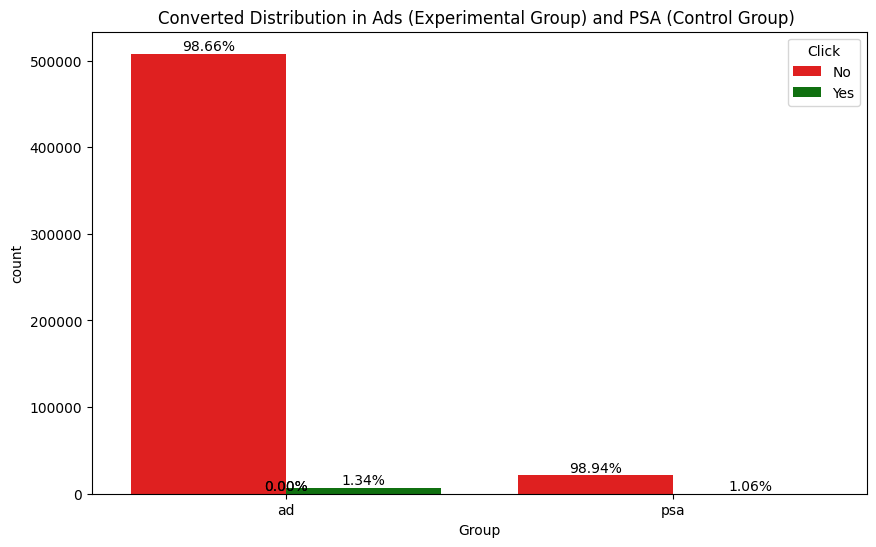

In [18]:
palette = {False: "red", True: "green"}
group_counts = ads_campaign.groupby('test_group').size()
plt.figure(figsize=(10,6))
ax = sns.countplot(x='test_group', hue='converted', data=ads_campaign, palette=palette)
plt.title('Converted Distribution in Ads (Experimental Group) and PSA (Control Group) ')
plt.xlabel('Group')
plt.legend(title='Click', labels=['No', 'Yes'])

for bar in ax.patches:
    group = 'ad' if bar.get_x() < 0.5 else 'psa'
    total = group_counts.loc[group]
    x = bar.get_x() + bar.get_width() / 2  # x-axis of bar
    y = bar.get_height()
    percentage = 100*y/total
    ax.text(x, y + 0.5, f"{percentage:.2f}%", ha='center', va='bottom')  # text aboves bar

Treatment Group Conversion rate: 1.34% \
Control Group Conversion rate: 1.06%

## Sample size check

To perform the z-statistic test in the analysis of the difference in proportions, it is necessary to assume that the sampling distribution of the proportion approaches a normal distribution. Based on the Central Limit Theorem (CLT), this assumption can be met even though the population distribution is not normal, as long as the sample size is large enough. The requirements for a sufficient sample size are $n_1.p_1\geq5, n_1.(1-p_1) \geq 5, n_2.p_2 \geq5$, and $n_2.(1-p_2)\geq5$ \
where, \
$n_1, n_2$ = sample sizes of groups 1 and 2, \
$p_1,p_2$  = sample proportions of groups 1 and 2

In [19]:
# Calculate succsess proportion
p1 = 0.0134
p2 = 0.0106
total_treatment = group_counts[0]
total_control = group_counts[1]

# Check wheter sample size is big enough for normal approximation
def check_sample_size(n, p):
    return (n * p >= 5) and (n * (1 - p) >= 5)

# Treatment Group check
treatment_check = check_sample_size(total_treatment, p1)

# Control Group check
control_check = check_sample_size(total_control, p2)

# Result
if treatment_check and control_check:
    print("Sample sizes are large enough for a Z-test.")
else:
    print("Sample sizes are too small; consider using an exact test (e.g., Fisher's exact test).")


Sample sizes are large enough for a Z-test.


## Conducting a Two-Proportion Z-test

In [20]:
outcome_group_counts = ads_campaign.groupby(['test_group','converted']).size().reset_index(name='count')
treatment_group = outcome_group_counts[outcome_group_counts['test_group'] == 'ad']
control_group = outcome_group_counts[outcome_group_counts['test_group'] == 'psa']

# Count successes (conversions)
successes = [
    treatment_group.loc[treatment_group["converted"] == 1, "count"].values[0],    # number of conversions in ad group
    control_group.loc[control_group["converted"] == 1, "count"].values[0]    # number of conversions in psa group
]

# Get sample sizes
nobs = [
    sum(treatment_group['count']),    # total number in ad group
    sum(control_group['count'])    # total number in psa group
]

# Calculate proportions
z_value, p_value = proportions_ztest(count=successes, nobs=nobs, alternative='larger')
if p_value < 0.05:
    print("Reject the Null Hypothesis")
else:
    print("Fail to reject the Null Hypothesis")

Reject the Null Hypothesis


There is statistical significance, indicating that the observed differences between the groups are unlikely to have occurred by chance alone. This suggests that the changes in the experimental group have a real effect compared to the control group. The 'ad' group demonstrates a notably higher conversion rate compared to the 'psa' group, indicating a statistically significant improvement from the ad campaign.

### Confidence interval for difference in conversion rate

In [21]:
# Data
success_group1 = successes[0] # Jumlah sukses di Grup 1
total_group1 = nobs[0]   # Total sampel di Grup 1

success_group2 = successes[1]  # Jumlah sukses di Grup 2
total_group2 = nobs[1]   # Total sampel di Grup 2

# Proportion
p1 = success_group1 / total_group1
p2 = success_group2 / total_group2

# Proportion difference
prop_diff = p1 - p2

# Pooled Standard Error
se = np.sqrt((p1 * (1 - p1)) / total_group1 + (p2 * (1 - p2)) / total_group2)

# Critical z-value for 95% CI
z_critical = norm.ppf(0.975)

# Confidence Interval
ci_lower = prop_diff - z_critical * se
ci_upper = prop_diff + z_critical * se

# Output
print(f"Proportion Difference: {prop_diff:.4f}")
print(f"95% Confidence Interval: ({ci_lower:.4f}, {ci_upper:.4f})")


Proportion Difference: 0.0028
95% Confidence Interval: (0.0014, 0.0042)


The confidence interval clearly shows a difference between the two groups, with the difference in conversion rate expected to be between 0.13% and 0.41% higher. Notably, the observed difference of 0.28% falls near the midpoint of the 95% confidence interval.

# Economic impact
After the significance test, the difference between the experimental group and the control group is statistically significant. However, before expanding the campaign advertising, a thorough cost-benefit analysis should be conducted, with the possibility of looking for alternative advertising strategies. The cost-benefit analysis can check whether the increase in conversion can cover the campaign costs or can check whether there is an increase in net profit. To assess the economic impact, we will determine the additional revenue generated for every 1,000 users after implementing the ad campaign, assuming an average revenue of $250 per conversion.

In [22]:
# Assume average revenue per conversion
avg_roi_per_conv = 25

# Calculate revenue for every 1000 users
ads_revenue = 1000 * p1 * avg_roi_per_conv
psa_revenue = 1000 * p2 * avg_roi_per_conv
additional_revenue = ads_revenue - psa_revenue

print(f'ADS revenue per 1K users :${ads_revenue:.2f}')
print(f'PSA revenue per 1K users :${psa_revenue:.2f}')
print(f'additional revenue per 1K users :${additional_revenue:.2f}')

ADS revenue per 1K users :$334.60
PSA revenue per 1K users :$264.91
additional revenue per 1K users :$69.69


The success of the ad campaign, reflected by an increase in revenue of $70 per 1000 users, ultimately depends on whether this additional revenue offsets the advertising costs. Based on the results of A/B testing and an economic analysis, the next step is to decide whether to continue with this ad campaign, revert to using PSAs, or explore alternative advertising strategies.